In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('heart.csv') # from: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

In [3]:
X, y = df.drop('target', axis=1), df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=9)

### Scale-insensitive

In [13]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=9)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=9)

In [5]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB()

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

### Scale-senstivie models

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()#n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression()

In [10]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_scaled, y_train)

SVC()

## Performance evaluation
* accuracy = (TP+TN)/ total
* Precision = TP / (TP+FP)
* Recalls (aka sensitivity) = TP / (TP+FN) = penalty on FN

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

Model SVC does not support predict_proba. Skipping.


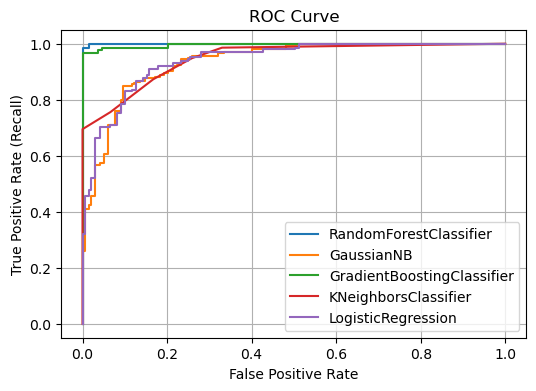

In [ ]:
# Plotting

def plot_roc_curve(_model, _X_test, _y_test, label, color):
    try:
        y_proba = _model.predict_proba(_X_test)[:, 1] # axis=1!!
        fpr, tpr, thresholds = roc_curve(_y_test, y_proba)
        ax.plot(fpr, tpr, label=label, color=color)
    except AttributeError:
        print(f"Model {label} does not support predict_proba. Skipping.")
    

fig, ax = plt.subplots(figsize=(6, 4))
models_list = [forest, nb_clf, gb_clf, knn, log_reg, svc]

for idx, this_model in enumerate(models_list):
    if idx < 3:
        plot_roc_curve(this_model, X_test, y_test, label=this_model.__class__.__name__, color=f'C{idx}')
    else:
        plot_roc_curve(this_model, X_test_scaled, y_test, label=this_model.__class__.__name__, color=f'C{idx}')


ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve')
ax.grid(True)
ax.legend(loc='lower right')
plt.show()

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Legend
from bokeh.io import output_notebook
from bokeh.palettes import Category10

output_notebook()

# Prepare data for Bokeh
plot_data = []
labels = []


def prepare_roc_data(_model, _X_test, _y_test):
    try:
        y_proba = _model.predict_proba(_X_test)[:, 1]
        fpr, tpr, _ = roc_curve(_y_test, y_proba)
        return fpr, tpr, _model.__class__.__name__
    except AttributeError:
        print(f"Model {_model.__class__.__name__} does not support predict_proba. Skipping.")
        return None

for idx, this_model in enumerate(models_list):
    if idx < 3:
        result = prepare_roc_data(this_model, X_test, y_test)
    else:
        result = prepare_roc_data(this_model, X_test_scaled, y_test)
    
    if result:
        fpr, tpr, label = result
        plot_data.append((fpr, tpr))
        labels.append(label)

# Create a Bokeh figure
p = figure(
    title="Bokeh ROC Curve", 
    x_axis_label="False Positive Rate", 
    y_axis_label="True Positive Rate (Recall)", 
    width=600, height=400
)

# Add lines for each model
renderers = []
colors = Category10[len(models_list)]
for fpr, tpr, label, color in zip(*zip(*plot_data), labels, colors):
    line = p.line(fpr, tpr, line_width=2, legend_label=label, color=color)
    renderers.append(line)

# Customize legend
p.legend.location = "bottom_right"
p.legend.title = "Models"
p.legend.click_policy = "hide"  # Allows hiding lines on click

# Show the plot
show(p)

**Memos to myself**:
- [ ] Understand why RandomForest yields the best performance

## Hyperparameter tuning

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500], # = number of trees
    'max_depth': [None, 10, 20, 30], # = upper bound of the nodes per tree
    'min_samples_split': [2, 5, 10], # = min. number of samples required to split a node
    "min_samples_leaf": [1, 2, 4], # = min. number of samples required to be at a leaf node
    "max_features": ['sqrt', 'log2', None], # = number of features to consider when looking for the best split
    #Other parameters:
    # min_weight_fraction_leaf=0.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None
}

forest = RandomForestClassifier(n_jobs=-1, random_state=9)
grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=9),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=2)

In [21]:
best_forest = grid_search.best_estimator_
print(best_forest)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=9)


## Feature importances

In [24]:
feature_importances = best_forest.feature_importances_
feature_names = best_forest.feature_names_in_

sorted_idx = np.argsort(feature_importances)
sorted_feature = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

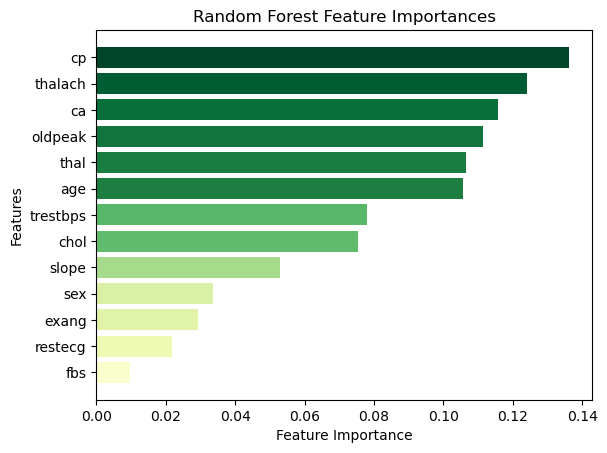

In [25]:
# Visualize the results
colors = plt.cm.YlGn(sorted_importances / max(sorted_importances))
plt.barh(sorted_feature, sorted_importances, color=colors)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances')
plt.show()


<Axes: >

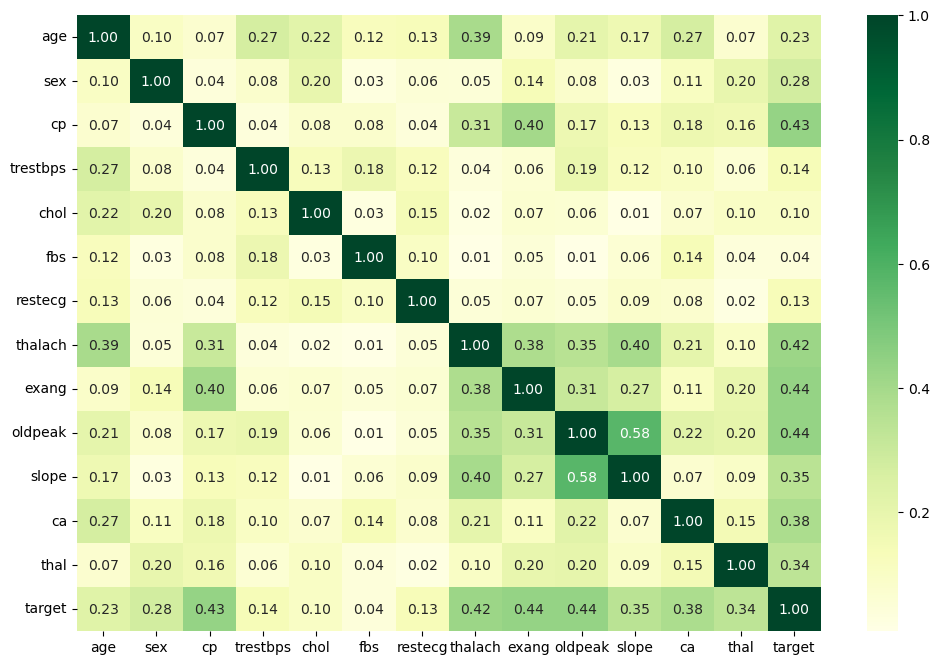

In [ ]:
# Check the correlation in the data
# Strong correlation does not neccesarily mean the features are important / significant

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(np.abs(df.corr()), annot=True, fmt=".2f", cmap='YlGn')